In [2]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

from utils import reader
from utils import dpcrUtils as utils
from utils import generator
from utils import reconstructor
from models import models

import torch
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
import itertools
import _pickle as cPickle
from torchviz import make_dot

device = utils.getDevice()
print ("Device:", device)
    
torch.no_grad()

seed_file = open('../utils/seed.txt', "r")
seed = int(seed_file.read())
seed_file.close()

print ("Using Seed:", seed)
    
torch.manual_seed(seed)
np.random.seed(seed)

Using 1 CUDA devices (GeForce GTX 1070)
Device: cuda
Using Seed: 34897567


In [8]:
from matplotlib import rcParams
rcParams['font.family'] = 'Century Schoolbook'
rcParams['font.cursive'] = 'Century Schoolbook'

rcParams['text.usetex'] = True 
rcParams['text.latex.preamble'] = [r'\usepackage{fouriernc}']

In [3]:
corrector = None

#predictor = models.loadModel('../training/checkpoints/predictor_multi_abc_cnet_mish_radam_sd/2020-12-30_201748/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_multi_simple_shapes_cnet_mish_radam_sd/2020-12-15_224339/detector_checkpoints.t7', device=device)

#predictor = models.loadModel('../hpc/results/predictor_multi_simple_shapes_cnet_mish_radam_sd/2020-12-19_062318/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_multi_simple_shapes_cnet_mish_radam_sd/2020-12-15_224339/detector_checkpoints.t7', device=device)

#predictor = models.loadModel('../hpc/results/predictor_multi_scans_cnet_mish_radam_sd/2020-12-19_064632/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_multi_scans_cnet_mish_radam_sd/2020-12-19_041509/detector_checkpoints.t7', device=device)

#predictor = models.loadModel('../hpc/results/predictor_multi_faces_cnet_mish_radam_sd/2020-12-15_224134/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_multi_faces_cnet_mish_radam_sd/2020-12-09_074025/detector_checkpoints.t7', device=device)
#corrector = models.loadModel('../hpc/results/corrector_multi_faces_cnet_mish_radam/2021-01-02_024609/corrector_checkpoints.t7', device=device)

#predictor = models.loadModel('../hpc/results/predictor_multi_cuboids_cnet_mish_radam_sd/2020-12-19_062203/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_multi_cuboids_cnet_mish_radam_sd/2020-12-15_224131/detector_checkpoints.t7', device=device)

#predictor = models.loadModel('../hpc/results/predictor_single_armadillo_cnet_mish_radam_sd/2020-12-15_224123/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_single_armadillo_cnet_mish_radam_sd/2020-12-15_224123/detector_checkpoints.t7', device=device)

#predictor = models.loadModel('../hpc/results/predictor_single_bunny_cnet_mish_radam_sd/2020-12-06_104726/predictor_checkpoints.t7', device=device)
predictor = models.loadModel('../hpc/results/predictor_single_bunny_cnet_mish_radam/2020-12-31_171657/predictor_checkpoints.t7', device=device)
detector = models.loadModel('../hpc/results/detector_single_bunny_cnet_mish_radam_sd/2020-12-08_110946/detector_checkpoints.t7', device=device)
corrector = models.loadModel('../hpc/results/corrector_single_bunny_cnet_mish_radam/2021-01-02_030713/corrector_checkpoints.t7', device=device)


#corrector = models.loadModel('../hpc/results/corrector_01_single_bunny_cnet_mish_radam_sd/2020-12-12_040206/corrector_checkpoints.t7', device=device)
#corrector = models.loadModel('../hpc/results/corrector_02_single_bunny_cnet_mish_radam_sd/2020-12-12_083939/corrector_checkpoints.t7', device=device)
#corrector = models.loadModel('../hpc/results/corrector_05_single_bunny_cnet_mish_radam_sd/2020-12-15_234102/corrector_checkpoints.t7', device=device)

#predictor = models.loadModel('../hpc/results/predictor_single_cube_cnet_mish_radam_sd/2020-12-06_164033/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_single_cube_cnet_mish_radam_sd/2020-12-06_103922/detector_checkpoints.t7', device=device, checkpoint=30)
#corrector = None

#predictor = models.loadModel('../hpc/results/predictor_single_tetrahedron_cnet_mish_radam_sd/2020-12-07_155445/predictor_checkpoints.t7', device=device)
#detector = models.loadModel('../hpc/results/detector_single_tetrahedron_cnet_mish_radam_sd/2020-12-07_094422/detector_checkpoints.t7', device=device, checkpoint=30)
#corrector = None


torch.cuda.empty_cache()

predictor.eval()
detector.eval()

print ("Load complete!")

Load complete!


In [6]:
sizes = 1000 + 1000 * np.arange(10)

N = 10

predictor_times_mean = []
predictor_times_std = []

detector_times_mean = []
detector_times_std = []

with torch.no_grad():
    
    for size in sizes:
        
        print ("size:", size)
    
        inp = torch.randn((4, 3, size)).to(device)

        predictor_times = []
        for i in range(N):
            start = time.time()
            out = predictor(inp)
            if (out.size(0) > 0):
                end = time.time()
                predictor_times.append(end -start)

        predictor_times = np.array(predictor_times)
        
        predictor_times_mean.append(np.mean(predictor_times))
        predictor_times_std.append(np.std(predictor_times))

        print ("prediction mean: %.4fms" % (np.mean(predictor_times)*1000))
        print ("prediction std: %.4fms" % (np.std(predictor_times)*1000))

        detector_times = []
        for i in range(N):
            start = time.time()
            out = detector(inp)
            if (out.size(0) > 0):
                end = time.time()
                detector_times.append(end -start)

        detector_times = np.array(detector_times)
                                   
        detector_times_mean.append(np.mean(detector_times))
        detector_times_std.append(np.std(detector_times))

        print ("detection mean: %.4fms" % (np.mean(detector_times)*1000))
        print ("detection std: %.4fms" % (np.std(detector_times)*1000))


size: 1000
prediction mean: 14.1001ms
prediction std: 0.5831ms
detection mean: 26.5999ms
detection std: 6.8844ms
size: 2000
prediction mean: 20.0000ms
prediction std: 16.1556ms
detection mean: 64.8501ms
detection std: 1.7754ms
size: 3000
prediction mean: 51.1499ms
prediction std: 42.2091ms
detection mean: 108.7496ms
detection std: 0.4604ms
size: 4000
prediction mean: 89.5001ms
prediction std: 69.0888ms
detection mean: 162.6499ms
detection std: 0.9499ms
size: 5000
prediction mean: 142.2997ms
prediction std: 97.2954ms
detection mean: 227.0001ms
detection std: 1.1617ms
size: 6000
prediction mean: 200.0501ms
prediction std: 125.2399ms
detection mean: 300.7000ms
detection std: 1.2475ms
size: 7000
prediction mean: 299.7501ms
prediction std: 138.3334ms
detection mean: 385.6000ms
detection std: 4.1743ms
size: 8000
prediction mean: 383.3001ms
prediction std: 159.8191ms
detection mean: 475.1998ms
detection std: 3.6892ms
size: 9000
prediction mean: 476.1001ms
prediction std: 180.5949ms
detection 

In [16]:
predictor_times_mean = np.array(predictor_times_mean)
predictor_times_std = np.array(predictor_times_std)

detector_times_mean = np.array(detector_times_mean)
detector_times_std = np.array(detector_times_std)

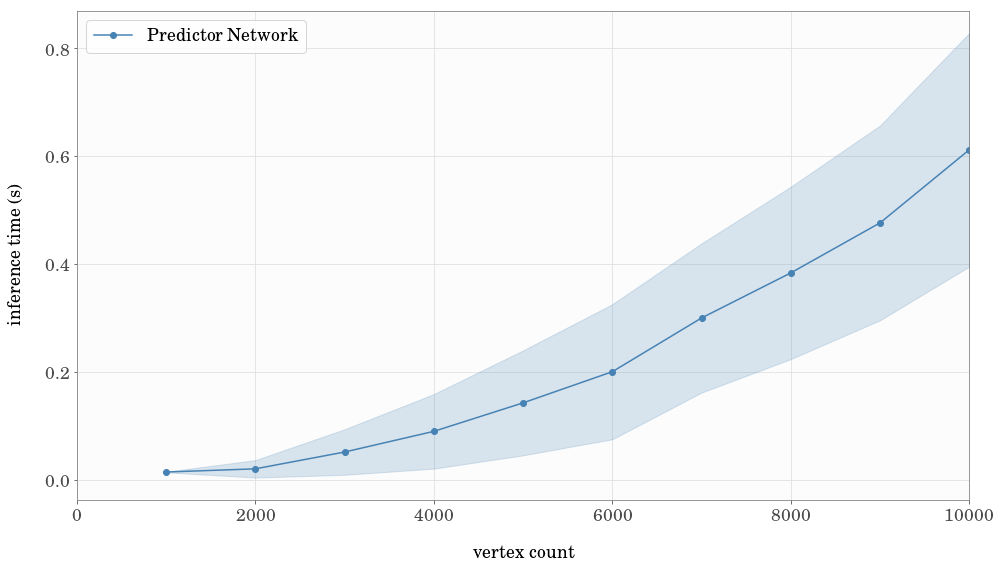

In [27]:
rcParams['font.size'] = '19'
    
plt.figure(figsize=(16,9))
ax = plt.axes()

plt.setp(ax.spines.values(), color=3 * [0.5])
ax.set_facecolor(3 * [0.99])
ax.tick_params(axis='x', colors=3 * [0.3])
ax.tick_params(axis='y', colors=3 * [0.3])

ax.set_xlim(0, sizes[-1]+0.5)

ax.plot(sizes, predictor_times_mean, label='Predictor Network', marker='o', color='steelblue')
ax.fill_between(sizes, predictor_times_mean + predictor_times_std, predictor_times_mean - predictor_times_std, color='steelblue', alpha=0.2)

#ax.plot(sizes, detector_times_mean, label='Detector', marker='o', color='orange')
#ax.fill_between(sizes, detector_times_mean + detector_times_std, detector_times_mean - detector_times_std, color='orange', alpha=0.2)

ax.set_xlabel('vertex count', labelpad =20)
ax.set_ylabel('inference time (s)', labelpad =20)

#ax.set_ylim(y_ticks[0], y_ticks[-1])
ax.legend(loc = 'upper left')
ax.set_axisbelow(True)
ax.grid(color=3 * [0.88])